# Recurrent Neural Networks

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Time series forecasting

In [2]:
df = pd.read_csv('../data/cansim-0800020-eng-6674700030567901031.csv',
                 skiprows=6, skipfooter=9,
                 engine='python')
df.head()

,Adjustments,Unadjusted,Seasonally adjusted
0,Jan-1991,12588862,15026890
1,Feb-1991,12154321,15304585
2,Mar-1991,14337072,15413591
3,Apr-1991,15108570,15293409
4,May-1991,17225734,15676083


In [3]:
from pandas.tseries.offsets import MonthEnd

In [4]:
df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)
df = df.set_index('Adjustments')
df.head()

/var/folders/9v/9dcjztmd5kxffqw73qlg37l40000gn/T/ipykernel_18219/3942898399.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Adjustments'] = pd.to_datetime(df['Adjustments']) + MonthEnd(1)


,Unadjusted,Seasonally adjusted
Adjustments,,
1991-01-31,12588862,15026890
1991-02-28,12154321,15304585
1991-03-31,14337072,15413591
1991-04-30,15108570,15293409
1991-05-31,17225734,15676083


<Axes: xlabel='Adjustments'>

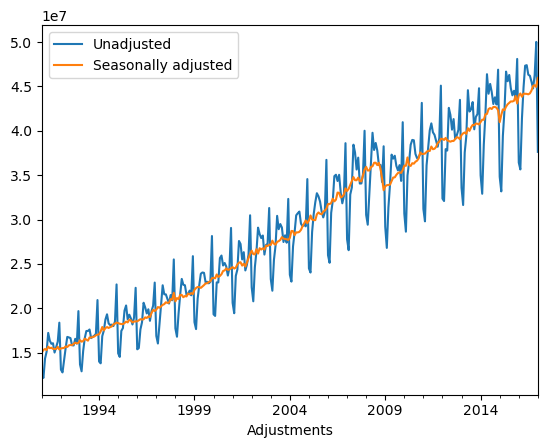

In [5]:
df.plot()

In [ ]:
split_date = pd.Timestamp('01-01-2011')

In [ ]:
train = df.loc[:split_date, ['Unadjusted']]
test = df.loc[split_date:, ['Unadjusted']]

In [ ]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [ ]:
train_sc[:4]

In [ ]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

### Fully connected predictor

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=1, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [ ]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

In [ ]:
model.fit(X_train, y_train, epochs=200,
          batch_size=2, verbose=1,
          callbacks=[early_stop])

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
plt.plot(y_test)
plt.plot(y_pred)

### Recurrent predictor

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
X_train.shape

In [ ]:
#3D tensor with shape (batch_size, timesteps, input_dim)
X_train[:, None].shape

In [ ]:
X_train_t = X_train[:, None]
X_test_t = X_test[:, None]

In [ ]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 1)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X_train_t, y_train,
          epochs=100, batch_size=1, verbose=1,
          callbacks=[early_stop])

In [ ]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Windows

In [ ]:
train_sc.shape

In [ ]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

In [ ]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [ ]:
train_sc_df.head(13)

In [ ]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [ ]:
X_train.head()

In [ ]:
X_train.shape

In [ ]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

### Fully Connected on Windows

In [ ]:
K.clear_session()

model = Sequential()
model.add(Dense(12, input_dim=12, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [ ]:
model.fit(X_train, y_train, epochs=200,
          batch_size=1, verbose=1, callbacks=[early_stop])

In [ ]:
y_pred = model.predict(X_test)
plt.plot(y_test)
plt.plot(y_pred)

### LSTM on Windows

In [ ]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 12)
X_test_t = X_test.reshape(X_test.shape[0], 1, 12)

In [ ]:
X_train_t.shape

In [ ]:
K.clear_session()
model = Sequential()

model.add(LSTM(6, input_shape=(1, 12)))

model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

In [ ]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=1, verbose=1, callbacks=[early_stop])

In [ ]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

## Exercise 1

In the model above we reshaped the input shape to: `(num_samples, 1, 12)`, i.e. we treated a window of 12 months as a vector of 12 coordinates that we simultaneously passed to all the LSTM nodes. An alternative way to look at the problem is to reshape the input to `(num_samples, 12, 1)`. This means we consider each input window as a sequence of 12 values that we will pass in sequence to the LSTM. In principle this looks like a more accurate description of our situation. But does it yield better predictions? Let's check it.

- Reshape `X_train` and `X_test` so that they represent a set of univariate sequences
- retrain the same LSTM(6) model, you'll have to adapt the `input_shape`
- check the performance of this new model, is it better at predicting the test data?

## Exercise 2

RNN models can be applied to images too. In general we can apply them to any data where there's a connnection between nearby units. Let's see how we can easily build a model that works with images.

- Load the MNIST data, by now you should be able to do it blindfolded :)
- reshape it so that an image looks like a long sequence of pixels
- create a recurrent model and train it on the training data
- how does it perform compared to a fully connected? How does it compare to Convolutional Neural Networks?

(feel free to run this exercise on a cloud GPU if it's too slow on your laptop)